In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../')

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] =  '1'

# Training a simple network

## Constructing the network

In [5]:
from torch import nn
from torch.nn import init
import torch.nn.functional as F

In [6]:
class BaseNet(nn.Module):

    def __init__(self, input_shape, output_shape):
        super(BaseNet, self).__init__()
        
        self.output_shape = output_shape
        self.input_shape = input_shape

        C, W, H = input_shape
        P, D = output_shape

        self.features = nn.Sequential(
            nn.Linear(C*W*H, 300),
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Linear(300, P*D)
        )

    def forward(self, x):
        C, W, H = self.input_shape
        P, D = self.output_shape
        
        x = x.view(-1, C*W*H) # C x W x H -> C * W * H
        
        x = self.features(x)

        x = self.classifier(x)
        

        return x.view(-1, P, D)


## Loading the dataset and splitting between train and valid

In [ ]:
from cpe775.dataset import CroppedFaceLandmarksDataset, FaceLandmarksDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import Compose
from cpe775.transforms import ToTensor, CropFace, ToGray, ToPILImage

In [8]:
batch_size = 32
random_seed = 42
valid_size = 0.2
shuffle = True

In [9]:
transforms = Compose([
                   ToPILImage(),
                   ToGray(),
                   ToTensor()
                 ])

In [10]:
# load the dataset
train_dataset = CroppedFaceLandmarksDataset(data_file='../data/train.npz',
                                            transform=transforms)
valid_dataset = CroppedFaceLandmarksDataset(data_file='../data/train.npz',
                                            transform=transforms)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=batch_size, sampler=train_sampler, num_workers=4)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=batch_size, sampler=valid_sampler, num_workers=4)

## Creating the model

In [11]:
net = BaseNet((1, 256, 256), (68, 2)) # input shape, output shape

In [12]:
net = torch.nn.DataParallel(net)
net = net.cuda()

## Creating the loss function

In [13]:
from cpe775.criterion import NRMSELoss

In [14]:
criterion = NRMSELoss()
criterion = criterion.cuda()

## Loading trainer

In [15]:
from cpe775.model import Model

In [16]:
 model = Model(net, criterion=criterion)

## Creating the optimizer

In [17]:
import torch

In [18]:
optimizer = torch.optim.SGD(net.parameters(), 0.01, momentum=0.9)

## Configuring

In [19]:
model.set_optimizer(optimizer)

## Setting callbacks

In [20]:
from cpe775 import callbacks

In [21]:
callback_list = [
        callbacks.Progbar(print_freq=40),
        callbacks.ModelCheckpoint('../results/basenet/checkpoint-v2.pth.tar', 'val_loss', mode='min')
    ]

## Performing the training

In [22]:
model.fit_loader(train_loader, 1000, val_loader=valid_loader,
                 callback=callbacks.Compose(callback_list), metrics={'rmse': NRMSELoss(weight=68)})

Epoch: [0][0/79]	Time 0.357 (0.357)	Data 0.146 (0.146)	Train Loss 2.843 (2.843)	Train Rmse 193.356 (193.356)	
Epoch: [0][40/79]	Time 0.010 (0.019)	Data 0.001 (0.005)	Train Loss 1.039 (1.563)	Train Rmse 70.684 (106.269)	
Val: [0/20]	Time 0.151 (0.151)	Data 0.144 (0.144)	Val Loss 0.847 (0.847)	Val Rmse 57.581 (57.581)	
Epoch: [1][0/79]	Time 0.171 (0.171)	Data 0.162 (0.162)	Train Loss 0.985 (0.985)	Train Rmse 66.988 (66.988)	
Epoch: [1][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 1.383 (0.921)	Train Rmse 94.056 (62.659)	
Val: [0/20]	Time 0.156 (0.156)	Data 0.147 (0.147)	Val Loss 0.796 (0.796)	Val Rmse 54.106 (54.106)	
Epoch: [2][0/79]	Time 0.165 (0.165)	Data 0.156 (0.156)	Train Loss 0.712 (0.712)	Train Rmse 48.422 (48.422)	
Epoch: [2][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.615 (0.916)	Train Rmse 41.852 (62.316)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.152 (0.152)	Val Loss 1.071 (1.071)	Val Rmse 72.835 (72.835)	
Epoch: [3][0/79]	Time 0.205 (0.205)	Data 0.196 (0

Epoch: [26][0/79]	Time 0.188 (0.188)	Data 0.179 (0.179)	Train Loss 0.251 (0.251)	Train Rmse 17.089 (17.089)	
Epoch: [26][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.276 (0.253)	Train Rmse 18.800 (17.233)	
Val: [0/20]	Time 0.153 (0.153)	Data 0.146 (0.146)	Val Loss 0.250 (0.250)	Val Rmse 17.016 (17.016)	
Epoch: [27][0/79]	Time 0.232 (0.232)	Data 0.223 (0.223)	Train Loss 0.244 (0.244)	Train Rmse 16.586 (16.586)	
Epoch: [27][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.264 (0.257)	Train Rmse 17.976 (17.477)	
Val: [0/20]	Time 0.155 (0.155)	Data 0.148 (0.148)	Val Loss 0.245 (0.245)	Val Rmse 16.641 (16.641)	
Epoch: [28][0/79]	Time 0.181 (0.181)	Data 0.172 (0.172)	Train Loss 0.239 (0.239)	Train Rmse 16.277 (16.277)	
Epoch: [28][40/79]	Time 0.009 (0.014)	Data 0.001 (0.005)	Train Loss 0.227 (0.255)	Train Rmse 15.403 (17.365)	
Val: [0/20]	Time 0.151 (0.151)	Data 0.143 (0.143)	Val Loss 0.234 (0.234)	Val Rmse 15.932 (15.932)	
Epoch: [29][0/79]	Time 0.192 (0.192)	Data 0.18

Epoch: [52][0/79]	Time 0.211 (0.211)	Data 0.203 (0.203)	Train Loss 0.238 (0.238)	Train Rmse 16.158 (16.158)	
Epoch: [52][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.226 (0.248)	Train Rmse 15.337 (16.848)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.153 (0.153)	Val Loss 0.222 (0.222)	Val Rmse 15.114 (15.114)	
Epoch: [53][0/79]	Time 0.223 (0.223)	Data 0.213 (0.213)	Train Loss 0.245 (0.245)	Train Rmse 16.684 (16.684)	
Epoch: [53][40/79]	Time 0.009 (0.015)	Data 0.001 (0.006)	Train Loss 0.229 (0.257)	Train Rmse 15.548 (17.458)	
Val: [0/20]	Time 0.151 (0.151)	Data 0.144 (0.144)	Val Loss 0.267 (0.267)	Val Rmse 18.180 (18.180)	
Epoch: [54][0/79]	Time 0.199 (0.199)	Data 0.189 (0.189)	Train Loss 0.260 (0.260)	Train Rmse 17.671 (17.671)	
Epoch: [54][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.282 (0.254)	Train Rmse 19.145 (17.252)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.153 (0.153)	Val Loss 0.226 (0.226)	Val Rmse 15.363 (15.363)	
Epoch: [55][0/79]	Time 0.196 (0.196)	Data 0.18

Epoch: [78][0/79]	Time 0.164 (0.164)	Data 0.155 (0.155)	Train Loss 0.245 (0.245)	Train Rmse 16.636 (16.636)	
Epoch: [78][40/79]	Time 0.010 (0.013)	Data 0.001 (0.005)	Train Loss 0.278 (0.254)	Train Rmse 18.898 (17.301)	
Val: [0/20]	Time 0.168 (0.168)	Data 0.161 (0.161)	Val Loss 0.243 (0.243)	Val Rmse 16.552 (16.552)	
Epoch: [79][0/79]	Time 0.153 (0.153)	Data 0.144 (0.144)	Train Loss 0.292 (0.292)	Train Rmse 19.864 (19.864)	
Epoch: [79][40/79]	Time 0.010 (0.013)	Data 0.001 (0.005)	Train Loss 0.203 (0.256)	Train Rmse 13.824 (17.390)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.153 (0.153)	Val Loss 0.254 (0.254)	Val Rmse 17.269 (17.269)	
Epoch: [80][0/79]	Time 0.161 (0.161)	Data 0.152 (0.152)	Train Loss 0.270 (0.270)	Train Rmse 18.339 (18.339)	
Epoch: [80][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.199 (0.254)	Train Rmse 13.512 (17.306)	
Val: [0/20]	Time 0.153 (0.153)	Data 0.145 (0.145)	Val Loss 0.321 (0.321)	Val Rmse 21.845 (21.845)	
Epoch: [81][0/79]	Time 0.177 (0.177)	Data 0.16

Epoch: [104][0/79]	Time 0.226 (0.226)	Data 0.218 (0.218)	Train Loss 0.257 (0.257)	Train Rmse 17.498 (17.498)	
Epoch: [104][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.224 (0.254)	Train Rmse 15.204 (17.298)	
Val: [0/20]	Time 0.157 (0.157)	Data 0.148 (0.148)	Val Loss 0.227 (0.227)	Val Rmse 15.468 (15.468)	
Epoch: [105][0/79]	Time 0.185 (0.185)	Data 0.176 (0.176)	Train Loss 0.230 (0.230)	Train Rmse 15.645 (15.645)	
Epoch: [105][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.197 (0.251)	Train Rmse 13.424 (17.072)	
Val: [0/20]	Time 0.170 (0.170)	Data 0.162 (0.162)	Val Loss 0.270 (0.270)	Val Rmse 18.388 (18.388)	
Epoch: [106][0/79]	Time 0.188 (0.188)	Data 0.180 (0.180)	Train Loss 0.267 (0.267)	Train Rmse 18.158 (18.158)	
Epoch: [106][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.249 (0.258)	Train Rmse 16.944 (17.549)	
Val: [0/20]	Time 0.161 (0.161)	Data 0.154 (0.154)	Val Loss 0.254 (0.254)	Val Rmse 17.299 (17.299)	
Epoch: [107][0/79]	Time 0.180 (0.180)	Da

Val: [0/20]	Time 0.162 (0.162)	Data 0.155 (0.155)	Val Loss 0.213 (0.213)	Val Rmse 14.503 (14.503)	
Epoch: [130][0/79]	Time 0.162 (0.162)	Data 0.154 (0.154)	Train Loss 0.251 (0.251)	Train Rmse 17.090 (17.090)	
Epoch: [130][40/79]	Time 0.009 (0.014)	Data 0.001 (0.005)	Train Loss 0.285 (0.257)	Train Rmse 19.367 (17.466)	
Val: [0/20]	Time 0.175 (0.175)	Data 0.168 (0.168)	Val Loss 0.245 (0.245)	Val Rmse 16.691 (16.691)	
Epoch: [131][0/79]	Time 0.179 (0.179)	Data 0.170 (0.170)	Train Loss 0.265 (0.265)	Train Rmse 18.031 (18.031)	
Epoch: [131][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.289 (0.257)	Train Rmse 19.620 (17.465)	
Val: [0/20]	Time 0.163 (0.163)	Data 0.155 (0.155)	Val Loss 0.212 (0.212)	Val Rmse 14.424 (14.424)	
Epoch: [132][0/79]	Time 0.196 (0.196)	Data 0.188 (0.188)	Train Loss 0.274 (0.274)	Train Rmse 18.663 (18.663)	
Epoch: [132][40/79]	Time 0.011 (0.015)	Data 0.001 (0.006)	Train Loss 0.232 (0.258)	Train Rmse 15.763 (17.536)	
Val: [0/20]	Time 0.159 (0.159)	Data 0.15

Epoch: [155][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.295 (0.257)	Train Rmse 20.044 (17.450)	
Val: [0/20]	Time 0.159 (0.159)	Data 0.152 (0.152)	Val Loss 0.272 (0.272)	Val Rmse 18.502 (18.502)	
Epoch: [156][0/79]	Time 0.166 (0.166)	Data 0.158 (0.158)	Train Loss 0.230 (0.230)	Train Rmse 15.646 (15.646)	
Epoch: [156][40/79]	Time 0.010 (0.013)	Data 0.001 (0.005)	Train Loss 0.222 (0.256)	Train Rmse 15.091 (17.375)	
Val: [0/20]	Time 0.164 (0.164)	Data 0.157 (0.157)	Val Loss 0.238 (0.238)	Val Rmse 16.165 (16.165)	
Epoch: [157][0/79]	Time 0.179 (0.179)	Data 0.171 (0.171)	Train Loss 0.273 (0.273)	Train Rmse 18.530 (18.530)	
Epoch: [157][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.279 (0.257)	Train Rmse 18.996 (17.443)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.153 (0.153)	Val Loss 0.254 (0.254)	Val Rmse 17.258 (17.258)	
Epoch: [158][0/79]	Time 0.177 (0.177)	Data 0.168 (0.168)	Train Loss 0.288 (0.288)	Train Rmse 19.567 (19.567)	
Epoch: [158][40/79]	Time 0.010 (0.014)	D

Epoch: [181][0/79]	Time 0.205 (0.205)	Data 0.197 (0.197)	Train Loss 0.199 (0.199)	Train Rmse 13.565 (13.565)	
Epoch: [181][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.272 (0.256)	Train Rmse 18.513 (17.379)	
Val: [0/20]	Time 0.155 (0.155)	Data 0.147 (0.147)	Val Loss 0.222 (0.222)	Val Rmse 15.108 (15.108)	
Epoch: [182][0/79]	Time 0.206 (0.206)	Data 0.198 (0.198)	Train Loss 0.224 (0.224)	Train Rmse 15.232 (15.232)	
Epoch: [182][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.237 (0.254)	Train Rmse 16.130 (17.242)	
Val: [0/20]	Time 0.159 (0.159)	Data 0.151 (0.151)	Val Loss 0.230 (0.230)	Val Rmse 15.660 (15.660)	
Epoch: [183][0/79]	Time 0.176 (0.176)	Data 0.168 (0.168)	Train Loss 0.240 (0.240)	Train Rmse 16.351 (16.351)	
Epoch: [183][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.271 (0.255)	Train Rmse 18.398 (17.346)	
Val: [0/20]	Time 0.156 (0.156)	Data 0.149 (0.149)	Val Loss 0.245 (0.245)	Val Rmse 16.674 (16.674)	
Epoch: [184][0/79]	Time 0.155 (0.155)	Da

Val: [0/20]	Time 0.161 (0.161)	Data 0.154 (0.154)	Val Loss 0.255 (0.255)	Val Rmse 17.352 (17.352)	
Epoch: [207][0/79]	Time 0.201 (0.201)	Data 0.192 (0.192)	Train Loss 0.214 (0.214)	Train Rmse 14.573 (14.573)	
Epoch: [207][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.268 (0.256)	Train Rmse 18.202 (17.431)	
Val: [0/20]	Time 0.163 (0.163)	Data 0.155 (0.155)	Val Loss 0.247 (0.247)	Val Rmse 16.815 (16.815)	
Epoch: [208][0/79]	Time 0.171 (0.171)	Data 0.162 (0.162)	Train Loss 0.312 (0.312)	Train Rmse 21.205 (21.205)	
Epoch: [208][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.238 (0.258)	Train Rmse 16.178 (17.542)	
Val: [0/20]	Time 0.164 (0.164)	Data 0.157 (0.157)	Val Loss 0.231 (0.231)	Val Rmse 15.711 (15.711)	
Epoch: [209][0/79]	Time 0.177 (0.177)	Data 0.168 (0.168)	Train Loss 0.226 (0.226)	Train Rmse 15.362 (15.362)	
Epoch: [209][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.248 (0.260)	Train Rmse 16.867 (17.662)	
Val: [0/20]	Time 0.150 (0.150)	Data 0.14

Epoch: [232][40/79]	Time 0.009 (0.014)	Data 0.001 (0.005)	Train Loss 0.308 (0.255)	Train Rmse 20.948 (17.363)	
Val: [0/20]	Time 0.162 (0.162)	Data 0.155 (0.155)	Val Loss 0.276 (0.276)	Val Rmse 18.775 (18.775)	
Epoch: [233][0/79]	Time 0.193 (0.193)	Data 0.182 (0.182)	Train Loss 0.262 (0.262)	Train Rmse 17.847 (17.847)	
Epoch: [233][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.227 (0.254)	Train Rmse 15.453 (17.257)	
Val: [0/20]	Time 0.167 (0.167)	Data 0.160 (0.160)	Val Loss 0.255 (0.255)	Val Rmse 17.354 (17.354)	
Epoch: [234][0/79]	Time 0.212 (0.212)	Data 0.203 (0.203)	Train Loss 0.276 (0.276)	Train Rmse 18.760 (18.760)	
Epoch: [234][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.332 (0.258)	Train Rmse 22.568 (17.562)	
Val: [0/20]	Time 0.166 (0.166)	Data 0.159 (0.159)	Val Loss 0.228 (0.228)	Val Rmse 15.476 (15.476)	
Epoch: [235][0/79]	Time 0.190 (0.190)	Data 0.180 (0.180)	Train Loss 0.276 (0.276)	Train Rmse 18.783 (18.783)	
Epoch: [235][40/79]	Time 0.010 (0.014)	D

Epoch: [258][0/79]	Time 0.175 (0.175)	Data 0.167 (0.167)	Train Loss 0.238 (0.238)	Train Rmse 16.160 (16.160)	
Epoch: [258][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.294 (0.255)	Train Rmse 20.010 (17.341)	
Val: [0/20]	Time 0.169 (0.169)	Data 0.162 (0.162)	Val Loss 0.270 (0.270)	Val Rmse 18.360 (18.360)	
Epoch: [259][0/79]	Time 0.160 (0.160)	Data 0.152 (0.152)	Train Loss 0.267 (0.267)	Train Rmse 18.165 (18.165)	
Epoch: [259][40/79]	Time 0.010 (0.013)	Data 0.001 (0.005)	Train Loss 0.272 (0.259)	Train Rmse 18.471 (17.614)	
Val: [0/20]	Time 0.167 (0.167)	Data 0.159 (0.159)	Val Loss 0.247 (0.247)	Val Rmse 16.772 (16.772)	
Epoch: [260][0/79]	Time 0.240 (0.240)	Data 0.230 (0.230)	Train Loss 0.223 (0.223)	Train Rmse 15.153 (15.153)	
Epoch: [260][40/79]	Time 0.010 (0.015)	Data 0.002 (0.007)	Train Loss 0.222 (0.252)	Train Rmse 15.072 (17.120)	
Val: [0/20]	Time 0.165 (0.165)	Data 0.158 (0.158)	Val Loss 0.263 (0.263)	Val Rmse 17.918 (17.918)	
Epoch: [261][0/79]	Time 0.188 (0.188)	Da

Val: [0/20]	Time 0.162 (0.162)	Data 0.155 (0.155)	Val Loss 0.270 (0.270)	Val Rmse 18.335 (18.335)	
Epoch: [284][0/79]	Time 0.217 (0.217)	Data 0.209 (0.209)	Train Loss 0.252 (0.252)	Train Rmse 17.140 (17.140)	
Epoch: [284][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.297 (0.250)	Train Rmse 20.193 (17.023)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.152 (0.152)	Val Loss 0.283 (0.283)	Val Rmse 19.252 (19.252)	
Epoch: [285][0/79]	Time 0.203 (0.203)	Data 0.194 (0.194)	Train Loss 0.278 (0.278)	Train Rmse 18.887 (18.887)	
Epoch: [285][40/79]	Time 0.010 (0.014)	Data 0.001 (0.006)	Train Loss 0.249 (0.258)	Train Rmse 16.941 (17.576)	
Val: [0/20]	Time 0.178 (0.178)	Data 0.170 (0.170)	Val Loss 0.235 (0.235)	Val Rmse 15.977 (15.977)	
Epoch: [286][0/79]	Time 0.179 (0.179)	Data 0.171 (0.171)	Train Loss 0.270 (0.270)	Train Rmse 18.344 (18.344)	
Epoch: [286][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.260 (0.254)	Train Rmse 17.689 (17.265)	
Val: [0/20]	Time 0.167 (0.167)	Data 0.16

Epoch: [309][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.238 (0.260)	Train Rmse 16.204 (17.652)	
Val: [0/20]	Time 0.172 (0.172)	Data 0.164 (0.164)	Val Loss 0.244 (0.244)	Val Rmse 16.587 (16.587)	
Epoch: [310][0/79]	Time 0.168 (0.168)	Data 0.156 (0.156)	Train Loss 0.230 (0.230)	Train Rmse 15.625 (15.625)	
Epoch: [310][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.270 (0.250)	Train Rmse 18.383 (16.998)	
Val: [0/20]	Time 0.175 (0.175)	Data 0.168 (0.168)	Val Loss 0.242 (0.242)	Val Rmse 16.482 (16.482)	
Epoch: [311][0/79]	Time 0.177 (0.177)	Data 0.168 (0.168)	Train Loss 0.254 (0.254)	Train Rmse 17.266 (17.266)	
Epoch: [311][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.279 (0.259)	Train Rmse 18.986 (17.602)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.152 (0.152)	Val Loss 0.208 (0.208)	Val Rmse 14.128 (14.128)	
Epoch: [312][0/79]	Time 0.182 (0.182)	Data 0.174 (0.174)	Train Loss 0.226 (0.226)	Train Rmse 15.384 (15.384)	
Epoch: [312][40/79]	Time 0.010 (0.014)	D

Epoch: [335][0/79]	Time 0.199 (0.199)	Data 0.191 (0.191)	Train Loss 0.241 (0.241)	Train Rmse 16.421 (16.421)	
Epoch: [335][40/79]	Time 0.009 (0.014)	Data 0.001 (0.005)	Train Loss 0.271 (0.254)	Train Rmse 18.430 (17.248)	
Val: [0/20]	Time 0.158 (0.158)	Data 0.151 (0.151)	Val Loss 0.197 (0.197)	Val Rmse 13.364 (13.364)	
Epoch: [336][0/79]	Time 0.194 (0.194)	Data 0.186 (0.186)	Train Loss 0.235 (0.235)	Train Rmse 15.983 (15.983)	
Epoch: [336][40/79]	Time 0.010 (0.014)	Data 0.001 (0.006)	Train Loss 0.286 (0.252)	Train Rmse 19.456 (17.108)	
Val: [0/20]	Time 0.162 (0.162)	Data 0.155 (0.155)	Val Loss 0.189 (0.189)	Val Rmse 12.822 (12.822)	
Epoch: [337][0/79]	Time 0.201 (0.201)	Data 0.193 (0.193)	Train Loss 0.290 (0.290)	Train Rmse 19.726 (19.726)	
Epoch: [337][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.268 (0.255)	Train Rmse 18.216 (17.365)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.152 (0.152)	Val Loss 0.255 (0.255)	Val Rmse 17.365 (17.365)	
Epoch: [338][0/79]	Time 0.202 (0.202)	Da

Val: [0/20]	Time 0.170 (0.170)	Data 0.162 (0.162)	Val Loss 0.261 (0.261)	Val Rmse 17.752 (17.752)	
Epoch: [361][0/79]	Time 0.171 (0.171)	Data 0.163 (0.163)	Train Loss 0.225 (0.225)	Train Rmse 15.293 (15.293)	
Epoch: [361][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.255 (0.254)	Train Rmse 17.371 (17.257)	
Val: [0/20]	Time 0.170 (0.170)	Data 0.162 (0.162)	Val Loss 0.285 (0.285)	Val Rmse 19.397 (19.397)	
Epoch: [362][0/79]	Time 0.190 (0.190)	Data 0.182 (0.182)	Train Loss 0.240 (0.240)	Train Rmse 16.291 (16.291)	
Epoch: [362][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.247 (0.256)	Train Rmse 16.797 (17.403)	
Val: [0/20]	Time 0.161 (0.161)	Data 0.154 (0.154)	Val Loss 0.276 (0.276)	Val Rmse 18.748 (18.748)	
Epoch: [363][0/79]	Time 0.181 (0.181)	Data 0.173 (0.173)	Train Loss 0.260 (0.260)	Train Rmse 17.689 (17.689)	
Epoch: [363][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.235 (0.251)	Train Rmse 15.958 (17.084)	
Val: [0/20]	Time 0.163 (0.163)	Data 0.15

Epoch: [386][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.229 (0.262)	Train Rmse 15.559 (17.791)	
Val: [0/20]	Time 0.159 (0.159)	Data 0.151 (0.151)	Val Loss 0.243 (0.243)	Val Rmse 16.505 (16.505)	
Epoch: [387][0/79]	Time 0.186 (0.186)	Data 0.178 (0.178)	Train Loss 0.263 (0.263)	Train Rmse 17.894 (17.894)	
Epoch: [387][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.212 (0.250)	Train Rmse 14.448 (16.982)	
Val: [0/20]	Time 0.161 (0.161)	Data 0.154 (0.154)	Val Loss 0.229 (0.229)	Val Rmse 15.543 (15.543)	
Epoch: [388][0/79]	Time 0.205 (0.205)	Data 0.197 (0.197)	Train Loss 0.245 (0.245)	Train Rmse 16.638 (16.638)	
Epoch: [388][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.296 (0.254)	Train Rmse 20.153 (17.286)	
Val: [0/20]	Time 0.168 (0.168)	Data 0.161 (0.161)	Val Loss 0.240 (0.240)	Val Rmse 16.338 (16.338)	
Epoch: [389][0/79]	Time 0.185 (0.185)	Data 0.176 (0.176)	Train Loss 0.271 (0.271)	Train Rmse 18.453 (18.453)	
Epoch: [389][40/79]	Time 0.010 (0.014)	D

Epoch: [412][0/79]	Time 0.222 (0.222)	Data 0.213 (0.213)	Train Loss 0.240 (0.240)	Train Rmse 16.311 (16.311)	
Epoch: [412][40/79]	Time 0.011 (0.015)	Data 0.001 (0.006)	Train Loss 0.240 (0.255)	Train Rmse 16.301 (17.335)	
Val: [0/20]	Time 0.166 (0.166)	Data 0.159 (0.159)	Val Loss 0.246 (0.246)	Val Rmse 16.714 (16.714)	
Epoch: [413][0/79]	Time 0.179 (0.179)	Data 0.171 (0.171)	Train Loss 0.266 (0.266)	Train Rmse 18.080 (18.080)	
Epoch: [413][40/79]	Time 0.010 (0.015)	Data 0.001 (0.005)	Train Loss 0.231 (0.250)	Train Rmse 15.737 (17.029)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.152 (0.152)	Val Loss 0.271 (0.271)	Val Rmse 18.410 (18.410)	
Epoch: [414][0/79]	Time 0.159 (0.159)	Data 0.150 (0.150)	Train Loss 0.251 (0.251)	Train Rmse 17.083 (17.083)	
Epoch: [414][40/79]	Time 0.010 (0.013)	Data 0.001 (0.005)	Train Loss 0.296 (0.259)	Train Rmse 20.098 (17.611)	
Val: [0/20]	Time 0.168 (0.168)	Data 0.160 (0.160)	Val Loss 0.228 (0.228)	Val Rmse 15.476 (15.476)	
Epoch: [415][0/79]	Time 0.178 (0.178)	Da

Val: [0/20]	Time 0.164 (0.164)	Data 0.156 (0.156)	Val Loss 0.247 (0.247)	Val Rmse 16.826 (16.826)	
Epoch: [438][0/79]	Time 0.174 (0.174)	Data 0.166 (0.166)	Train Loss 0.220 (0.220)	Train Rmse 14.987 (14.987)	
Epoch: [438][40/79]	Time 0.009 (0.014)	Data 0.001 (0.005)	Train Loss 0.223 (0.257)	Train Rmse 15.179 (17.499)	
Val: [0/20]	Time 0.170 (0.170)	Data 0.162 (0.162)	Val Loss 0.246 (0.246)	Val Rmse 16.701 (16.701)	
Epoch: [439][0/79]	Time 0.216 (0.216)	Data 0.206 (0.206)	Train Loss 0.249 (0.249)	Train Rmse 16.924 (16.924)	
Epoch: [439][40/79]	Time 0.009 (0.015)	Data 0.001 (0.006)	Train Loss 0.297 (0.249)	Train Rmse 20.203 (16.949)	
Val: [0/20]	Time 0.172 (0.172)	Data 0.164 (0.164)	Val Loss 0.266 (0.266)	Val Rmse 18.082 (18.082)	
Epoch: [440][0/79]	Time 0.186 (0.186)	Data 0.178 (0.178)	Train Loss 0.278 (0.278)	Train Rmse 18.876 (18.876)	
Epoch: [440][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.249 (0.256)	Train Rmse 16.938 (17.378)	
Val: [0/20]	Time 0.176 (0.176)	Data 0.16

Epoch: [463][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.270 (0.255)	Train Rmse 18.328 (17.321)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.152 (0.152)	Val Loss 0.195 (0.195)	Val Rmse 13.270 (13.270)	
Epoch: [464][0/79]	Time 0.189 (0.189)	Data 0.181 (0.181)	Train Loss 0.232 (0.232)	Train Rmse 15.804 (15.804)	
Epoch: [464][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.258 (0.251)	Train Rmse 17.564 (17.060)	
Val: [0/20]	Time 0.169 (0.169)	Data 0.162 (0.162)	Val Loss 0.279 (0.279)	Val Rmse 18.960 (18.960)	
Epoch: [465][0/79]	Time 0.174 (0.174)	Data 0.166 (0.166)	Train Loss 0.234 (0.234)	Train Rmse 15.888 (15.888)	
Epoch: [465][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.249 (0.255)	Train Rmse 16.933 (17.319)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.152 (0.152)	Val Loss 0.262 (0.262)	Val Rmse 17.838 (17.838)	
Epoch: [466][0/79]	Time 0.197 (0.197)	Data 0.186 (0.186)	Train Loss 0.222 (0.222)	Train Rmse 15.126 (15.126)	
Epoch: [466][40/79]	Time 0.010 (0.014)	D

Epoch: [489][0/79]	Time 0.184 (0.184)	Data 0.176 (0.176)	Train Loss 0.237 (0.237)	Train Rmse 16.140 (16.140)	
Epoch: [489][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.221 (0.250)	Train Rmse 15.027 (17.015)	
Val: [0/20]	Time 0.164 (0.164)	Data 0.157 (0.157)	Val Loss 0.262 (0.262)	Val Rmse 17.804 (17.804)	
Epoch: [490][0/79]	Time 0.181 (0.181)	Data 0.173 (0.173)	Train Loss 0.259 (0.259)	Train Rmse 17.594 (17.594)	
Epoch: [490][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.247 (0.256)	Train Rmse 16.826 (17.392)	
Val: [0/20]	Time 0.170 (0.170)	Data 0.161 (0.161)	Val Loss 0.262 (0.262)	Val Rmse 17.807 (17.807)	
Epoch: [491][0/79]	Time 0.173 (0.173)	Data 0.165 (0.165)	Train Loss 0.229 (0.229)	Train Rmse 15.586 (15.586)	
Epoch: [491][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.250 (0.251)	Train Rmse 17.008 (17.086)	
Val: [0/20]	Time 0.163 (0.163)	Data 0.154 (0.154)	Val Loss 0.204 (0.204)	Val Rmse 13.879 (13.879)	
Epoch: [492][0/79]	Time 0.214 (0.214)	Da

Val: [0/20]	Time 0.168 (0.168)	Data 0.160 (0.160)	Val Loss 0.244 (0.244)	Val Rmse 16.611 (16.611)	
Epoch: [515][0/79]	Time 0.217 (0.217)	Data 0.209 (0.209)	Train Loss 0.300 (0.300)	Train Rmse 20.397 (20.397)	
Epoch: [515][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.214 (0.260)	Train Rmse 14.568 (17.707)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.152 (0.152)	Val Loss 0.268 (0.268)	Val Rmse 18.206 (18.206)	
Epoch: [516][0/79]	Time 0.196 (0.196)	Data 0.188 (0.188)	Train Loss 0.243 (0.243)	Train Rmse 16.515 (16.515)	
Epoch: [516][40/79]	Time 0.009 (0.014)	Data 0.001 (0.006)	Train Loss 0.251 (0.253)	Train Rmse 17.096 (17.200)	
Val: [0/20]	Time 0.165 (0.165)	Data 0.158 (0.158)	Val Loss 0.237 (0.237)	Val Rmse 16.111 (16.111)	
Epoch: [517][0/79]	Time 0.198 (0.198)	Data 0.189 (0.189)	Train Loss 0.261 (0.261)	Train Rmse 17.717 (17.717)	
Epoch: [517][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.286 (0.251)	Train Rmse 19.480 (17.057)	
Val: [0/20]	Time 0.158 (0.158)	Data 0.15

Epoch: [540][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.250 (0.258)	Train Rmse 17.002 (17.524)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.153 (0.153)	Val Loss 0.254 (0.254)	Val Rmse 17.246 (17.246)	
Epoch: [541][0/79]	Time 0.194 (0.194)	Data 0.186 (0.186)	Train Loss 0.264 (0.264)	Train Rmse 17.943 (17.943)	
Epoch: [541][40/79]	Time 0.010 (0.015)	Data 0.000 (0.006)	Train Loss 0.251 (0.255)	Train Rmse 17.099 (17.372)	
Val: [0/20]	Time 0.159 (0.159)	Data 0.152 (0.152)	Val Loss 0.275 (0.275)	Val Rmse 18.670 (18.670)	
Epoch: [542][0/79]	Time 0.236 (0.236)	Data 0.227 (0.227)	Train Loss 0.220 (0.220)	Train Rmse 14.981 (14.981)	
Epoch: [542][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.297 (0.254)	Train Rmse 20.204 (17.284)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.153 (0.153)	Val Loss 0.255 (0.255)	Val Rmse 17.341 (17.341)	
Epoch: [543][0/79]	Time 0.172 (0.172)	Data 0.164 (0.164)	Train Loss 0.245 (0.245)	Train Rmse 16.691 (16.691)	
Epoch: [543][40/79]	Time 0.010 (0.014)	D

Epoch: [566][0/79]	Time 0.171 (0.171)	Data 0.163 (0.163)	Train Loss 0.323 (0.323)	Train Rmse 21.975 (21.975)	
Epoch: [566][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.233 (0.258)	Train Rmse 15.860 (17.529)	
Val: [0/20]	Time 0.167 (0.167)	Data 0.160 (0.160)	Val Loss 0.228 (0.228)	Val Rmse 15.510 (15.510)	
Epoch: [567][0/79]	Time 0.166 (0.166)	Data 0.156 (0.156)	Train Loss 0.211 (0.211)	Train Rmse 14.318 (14.318)	
Epoch: [567][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.260 (0.257)	Train Rmse 17.696 (17.510)	
Val: [0/20]	Time 0.159 (0.159)	Data 0.152 (0.152)	Val Loss 0.263 (0.263)	Val Rmse 17.867 (17.867)	
Epoch: [568][0/79]	Time 0.188 (0.188)	Data 0.179 (0.179)	Train Loss 0.223 (0.223)	Train Rmse 15.188 (15.188)	
Epoch: [568][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.310 (0.257)	Train Rmse 21.060 (17.484)	
Val: [0/20]	Time 0.167 (0.167)	Data 0.159 (0.159)	Val Loss 0.226 (0.226)	Val Rmse 15.372 (15.372)	
Epoch: [569][0/79]	Time 0.248 (0.248)	Da

Val: [0/20]	Time 0.160 (0.160)	Data 0.152 (0.152)	Val Loss 0.211 (0.211)	Val Rmse 14.317 (14.317)	
Epoch: [592][0/79]	Time 0.198 (0.198)	Data 0.189 (0.189)	Train Loss 0.255 (0.255)	Train Rmse 17.323 (17.323)	
Epoch: [592][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.228 (0.255)	Train Rmse 15.513 (17.365)	
Val: [0/20]	Time 0.158 (0.158)	Data 0.151 (0.151)	Val Loss 0.258 (0.258)	Val Rmse 17.577 (17.577)	
Epoch: [593][0/79]	Time 0.213 (0.213)	Data 0.205 (0.205)	Train Loss 0.291 (0.291)	Train Rmse 19.820 (19.820)	
Epoch: [593][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.265 (0.259)	Train Rmse 18.010 (17.641)	
Val: [0/20]	Time 0.161 (0.161)	Data 0.153 (0.153)	Val Loss 0.239 (0.239)	Val Rmse 16.252 (16.252)	
Epoch: [594][0/79]	Time 0.220 (0.220)	Data 0.211 (0.211)	Train Loss 0.236 (0.236)	Train Rmse 16.035 (16.035)	
Epoch: [594][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.272 (0.256)	Train Rmse 18.486 (17.420)	
Val: [0/20]	Time 0.158 (0.158)	Data 0.15

Epoch: [617][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.229 (0.260)	Train Rmse 15.560 (17.707)	
Val: [0/20]	Time 0.169 (0.169)	Data 0.162 (0.162)	Val Loss 0.213 (0.213)	Val Rmse 14.517 (14.517)	
Epoch: [618][0/79]	Time 0.177 (0.177)	Data 0.169 (0.169)	Train Loss 0.243 (0.243)	Train Rmse 16.529 (16.529)	
Epoch: [618][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.254 (0.257)	Train Rmse 17.256 (17.461)	
Val: [0/20]	Time 0.157 (0.157)	Data 0.150 (0.150)	Val Loss 0.307 (0.307)	Val Rmse 20.867 (20.867)	
Epoch: [619][0/79]	Time 0.225 (0.225)	Data 0.216 (0.216)	Train Loss 0.253 (0.253)	Train Rmse 17.210 (17.210)	
Epoch: [619][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.256 (0.248)	Train Rmse 17.389 (16.854)	
Val: [0/20]	Time 0.161 (0.161)	Data 0.154 (0.154)	Val Loss 0.270 (0.270)	Val Rmse 18.358 (18.358)	
Epoch: [620][0/79]	Time 0.173 (0.173)	Data 0.165 (0.165)	Train Loss 0.266 (0.266)	Train Rmse 18.110 (18.110)	
Epoch: [620][40/79]	Time 0.010 (0.014)	D

Epoch: [643][0/79]	Time 0.182 (0.182)	Data 0.172 (0.172)	Train Loss 0.215 (0.215)	Train Rmse 14.641 (14.641)	
Epoch: [643][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.257 (0.254)	Train Rmse 17.506 (17.298)	
Val: [0/20]	Time 0.159 (0.159)	Data 0.152 (0.152)	Val Loss 0.256 (0.256)	Val Rmse 17.406 (17.406)	
Epoch: [644][0/79]	Time 0.199 (0.199)	Data 0.191 (0.191)	Train Loss 0.236 (0.236)	Train Rmse 16.068 (16.068)	
Epoch: [644][40/79]	Time 0.012 (0.015)	Data 0.004 (0.006)	Train Loss 0.279 (0.254)	Train Rmse 18.999 (17.304)	
Val: [0/20]	Time 0.168 (0.168)	Data 0.161 (0.161)	Val Loss 0.251 (0.251)	Val Rmse 17.079 (17.079)	
Epoch: [645][0/79]	Time 0.213 (0.213)	Data 0.203 (0.203)	Train Loss 0.230 (0.230)	Train Rmse 15.621 (15.621)	
Epoch: [645][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.306 (0.254)	Train Rmse 20.829 (17.270)	
Val: [0/20]	Time 0.165 (0.165)	Data 0.157 (0.157)	Val Loss 0.254 (0.254)	Val Rmse 17.273 (17.273)	
Epoch: [646][0/79]	Time 0.182 (0.182)	Da

Val: [0/20]	Time 0.170 (0.170)	Data 0.162 (0.162)	Val Loss 0.236 (0.236)	Val Rmse 16.079 (16.079)	
Epoch: [669][0/79]	Time 0.191 (0.191)	Data 0.182 (0.182)	Train Loss 0.268 (0.268)	Train Rmse 18.192 (18.192)	
Epoch: [669][40/79]	Time 0.009 (0.014)	Data 0.001 (0.005)	Train Loss 0.249 (0.251)	Train Rmse 16.944 (17.072)	
Val: [0/20]	Time 0.158 (0.158)	Data 0.151 (0.151)	Val Loss 0.280 (0.280)	Val Rmse 19.040 (19.040)	
Epoch: [670][0/79]	Time 0.220 (0.220)	Data 0.211 (0.211)	Train Loss 0.236 (0.236)	Train Rmse 16.069 (16.069)	
Epoch: [670][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.277 (0.252)	Train Rmse 18.821 (17.131)	
Val: [0/20]	Time 0.166 (0.166)	Data 0.159 (0.159)	Val Loss 0.223 (0.223)	Val Rmse 15.141 (15.141)	
Epoch: [671][0/79]	Time 0.180 (0.180)	Data 0.171 (0.171)	Train Loss 0.245 (0.245)	Train Rmse 16.629 (16.629)	
Epoch: [671][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.264 (0.257)	Train Rmse 17.931 (17.481)	
Val: [0/20]	Time 0.168 (0.168)	Data 0.16

Epoch: [694][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.254 (0.260)	Train Rmse 17.247 (17.660)	
Val: [0/20]	Time 0.166 (0.166)	Data 0.159 (0.159)	Val Loss 0.261 (0.261)	Val Rmse 17.730 (17.730)	
Epoch: [695][0/79]	Time 0.201 (0.201)	Data 0.194 (0.194)	Train Loss 0.289 (0.289)	Train Rmse 19.665 (19.665)	
Epoch: [695][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.245 (0.256)	Train Rmse 16.669 (17.426)	
Val: [0/20]	Time 0.158 (0.158)	Data 0.150 (0.150)	Val Loss 0.246 (0.246)	Val Rmse 16.713 (16.713)	
Epoch: [696][0/79]	Time 0.176 (0.176)	Data 0.168 (0.168)	Train Loss 0.277 (0.277)	Train Rmse 18.806 (18.806)	
Epoch: [696][40/79]	Time 0.009 (0.014)	Data 0.001 (0.005)	Train Loss 0.262 (0.259)	Train Rmse 17.840 (17.638)	
Val: [0/20]	Time 0.167 (0.167)	Data 0.159 (0.159)	Val Loss 0.217 (0.217)	Val Rmse 14.731 (14.731)	
Epoch: [697][0/79]	Time 0.188 (0.188)	Data 0.180 (0.180)	Train Loss 0.260 (0.260)	Train Rmse 17.656 (17.656)	
Epoch: [697][40/79]	Time 0.010 (0.014)	D

Epoch: [720][0/79]	Time 0.175 (0.175)	Data 0.167 (0.167)	Train Loss 0.251 (0.251)	Train Rmse 17.070 (17.070)	
Epoch: [720][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.294 (0.256)	Train Rmse 19.975 (17.441)	
Val: [0/20]	Time 0.174 (0.174)	Data 0.166 (0.166)	Val Loss 0.268 (0.268)	Val Rmse 18.207 (18.207)	
Epoch: [721][0/79]	Time 0.175 (0.175)	Data 0.167 (0.167)	Train Loss 0.264 (0.264)	Train Rmse 17.983 (17.983)	
Epoch: [721][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.253 (0.257)	Train Rmse 17.172 (17.469)	
Val: [0/20]	Time 0.159 (0.159)	Data 0.151 (0.151)	Val Loss 0.240 (0.240)	Val Rmse 16.333 (16.333)	
Epoch: [722][0/79]	Time 0.186 (0.186)	Data 0.178 (0.178)	Train Loss 0.214 (0.214)	Train Rmse 14.544 (14.544)	
Epoch: [722][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.261 (0.252)	Train Rmse 17.770 (17.141)	
Val: [0/20]	Time 0.177 (0.177)	Data 0.169 (0.169)	Val Loss 0.278 (0.278)	Val Rmse 18.892 (18.892)	
Epoch: [723][0/79]	Time 0.182 (0.182)	Da

Val: [0/20]	Time 0.161 (0.161)	Data 0.154 (0.154)	Val Loss 0.245 (0.245)	Val Rmse 16.679 (16.679)	
Epoch: [746][0/79]	Time 0.184 (0.184)	Data 0.175 (0.175)	Train Loss 0.321 (0.321)	Train Rmse 21.847 (21.847)	
Epoch: [746][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.278 (0.259)	Train Rmse 18.889 (17.584)	
Val: [0/20]	Time 0.167 (0.167)	Data 0.159 (0.159)	Val Loss 0.231 (0.231)	Val Rmse 15.712 (15.712)	
Epoch: [747][0/79]	Time 0.173 (0.173)	Data 0.165 (0.165)	Train Loss 0.213 (0.213)	Train Rmse 14.453 (14.453)	
Epoch: [747][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.234 (0.257)	Train Rmse 15.914 (17.449)	
Val: [0/20]	Time 0.169 (0.169)	Data 0.162 (0.162)	Val Loss 0.194 (0.194)	Val Rmse 13.216 (13.216)	
Epoch: [748][0/79]	Time 0.169 (0.169)	Data 0.160 (0.160)	Train Loss 0.262 (0.262)	Train Rmse 17.809 (17.809)	
Epoch: [748][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.287 (0.259)	Train Rmse 19.527 (17.636)	
Val: [0/20]	Time 0.168 (0.168)	Data 0.16

Epoch: [771][40/79]	Time 0.009 (0.014)	Data 0.001 (0.005)	Train Loss 0.244 (0.256)	Train Rmse 16.569 (17.427)	
Val: [0/20]	Time 0.163 (0.163)	Data 0.155 (0.155)	Val Loss 0.237 (0.237)	Val Rmse 16.109 (16.109)	
Epoch: [772][0/79]	Time 0.170 (0.170)	Data 0.161 (0.161)	Train Loss 0.220 (0.220)	Train Rmse 14.964 (14.964)	
Epoch: [772][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.294 (0.253)	Train Rmse 20.011 (17.193)	
Val: [0/20]	Time 0.158 (0.158)	Data 0.151 (0.151)	Val Loss 0.253 (0.253)	Val Rmse 17.219 (17.219)	
Epoch: [773][0/79]	Time 0.204 (0.204)	Data 0.194 (0.194)	Train Loss 0.261 (0.261)	Train Rmse 17.763 (17.763)	
Epoch: [773][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.237 (0.251)	Train Rmse 16.134 (17.053)	
Val: [0/20]	Time 0.171 (0.171)	Data 0.163 (0.163)	Val Loss 0.247 (0.247)	Val Rmse 16.787 (16.787)	
Epoch: [774][0/79]	Time 0.177 (0.177)	Data 0.169 (0.169)	Train Loss 0.262 (0.262)	Train Rmse 17.829 (17.829)	
Epoch: [774][40/79]	Time 0.010 (0.014)	D

Epoch: [797][0/79]	Time 0.215 (0.215)	Data 0.207 (0.207)	Train Loss 0.266 (0.266)	Train Rmse 18.111 (18.111)	
Epoch: [797][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.232 (0.255)	Train Rmse 15.801 (17.363)	
Val: [0/20]	Time 0.183 (0.183)	Data 0.175 (0.175)	Val Loss 0.267 (0.267)	Val Rmse 18.165 (18.165)	
Epoch: [798][0/79]	Time 0.164 (0.164)	Data 0.156 (0.156)	Train Loss 0.271 (0.271)	Train Rmse 18.452 (18.452)	
Epoch: [798][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.266 (0.250)	Train Rmse 18.057 (17.033)	
Val: [0/20]	Time 0.171 (0.171)	Data 0.162 (0.162)	Val Loss 0.206 (0.206)	Val Rmse 13.980 (13.980)	
Epoch: [799][0/79]	Time 0.214 (0.214)	Data 0.206 (0.206)	Train Loss 0.232 (0.232)	Train Rmse 15.767 (15.767)	
Epoch: [799][40/79]	Time 0.009 (0.015)	Data 0.001 (0.006)	Train Loss 0.274 (0.256)	Train Rmse 18.644 (17.412)	
Val: [0/20]	Time 0.163 (0.163)	Data 0.156 (0.156)	Val Loss 0.269 (0.269)	Val Rmse 18.268 (18.268)	
Epoch: [800][0/79]	Time 0.209 (0.209)	Da

Val: [0/20]	Time 0.159 (0.159)	Data 0.152 (0.152)	Val Loss 0.217 (0.217)	Val Rmse 14.759 (14.759)	
Epoch: [823][0/79]	Time 0.184 (0.184)	Data 0.174 (0.174)	Train Loss 0.277 (0.277)	Train Rmse 18.822 (18.822)	
Epoch: [823][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.304 (0.255)	Train Rmse 20.651 (17.362)	
Val: [0/20]	Time 0.161 (0.161)	Data 0.154 (0.154)	Val Loss 0.219 (0.219)	Val Rmse 14.866 (14.866)	
Epoch: [824][0/79]	Time 0.219 (0.219)	Data 0.210 (0.210)	Train Loss 0.254 (0.254)	Train Rmse 17.252 (17.252)	
Epoch: [824][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.228 (0.262)	Train Rmse 15.474 (17.810)	
Val: [0/20]	Time 0.168 (0.168)	Data 0.159 (0.159)	Val Loss 0.212 (0.212)	Val Rmse 14.438 (14.438)	
Epoch: [825][0/79]	Time 0.213 (0.213)	Data 0.203 (0.203)	Train Loss 0.240 (0.240)	Train Rmse 16.326 (16.326)	
Epoch: [825][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.245 (0.254)	Train Rmse 16.628 (17.279)	
Val: [0/20]	Time 0.167 (0.167)	Data 0.15

Epoch: [848][40/79]	Time 0.009 (0.015)	Data 0.001 (0.006)	Train Loss 0.264 (0.256)	Train Rmse 17.949 (17.406)	
Val: [0/20]	Time 0.162 (0.162)	Data 0.155 (0.155)	Val Loss 0.224 (0.224)	Val Rmse 15.260 (15.260)	
Epoch: [849][0/79]	Time 0.185 (0.185)	Data 0.176 (0.176)	Train Loss 0.267 (0.267)	Train Rmse 18.177 (18.177)	
Epoch: [849][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.281 (0.252)	Train Rmse 19.121 (17.151)	
Val: [0/20]	Time 0.158 (0.158)	Data 0.150 (0.150)	Val Loss 0.291 (0.291)	Val Rmse 19.801 (19.801)	
Epoch: [850][0/79]	Time 0.219 (0.219)	Data 0.211 (0.211)	Train Loss 0.203 (0.203)	Train Rmse 13.799 (13.799)	
Epoch: [850][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.254 (0.253)	Train Rmse 17.305 (17.188)	
Val: [0/20]	Time 0.163 (0.163)	Data 0.156 (0.156)	Val Loss 0.220 (0.220)	Val Rmse 14.989 (14.989)	
Epoch: [851][0/79]	Time 0.231 (0.231)	Data 0.223 (0.223)	Train Loss 0.302 (0.302)	Train Rmse 20.548 (20.548)	
Epoch: [851][40/79]	Time 0.010 (0.015)	D

Epoch: [874][0/79]	Time 0.199 (0.199)	Data 0.191 (0.191)	Train Loss 0.255 (0.255)	Train Rmse 17.325 (17.325)	
Epoch: [874][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.235 (0.257)	Train Rmse 15.993 (17.462)	
Val: [0/20]	Time 0.164 (0.164)	Data 0.157 (0.157)	Val Loss 0.241 (0.241)	Val Rmse 16.358 (16.358)	
Epoch: [875][0/79]	Time 0.203 (0.203)	Data 0.194 (0.194)	Train Loss 0.296 (0.296)	Train Rmse 20.126 (20.126)	
Epoch: [875][40/79]	Time 0.010 (0.014)	Data 0.001 (0.006)	Train Loss 0.302 (0.258)	Train Rmse 20.530 (17.539)	
Val: [0/20]	Time 0.177 (0.177)	Data 0.169 (0.169)	Val Loss 0.263 (0.263)	Val Rmse 17.857 (17.857)	
Epoch: [876][0/79]	Time 0.244 (0.244)	Data 0.235 (0.235)	Train Loss 0.243 (0.243)	Train Rmse 16.497 (16.497)	
Epoch: [876][40/79]	Time 0.010 (0.015)	Data 0.001 (0.007)	Train Loss 0.266 (0.254)	Train Rmse 18.112 (17.276)	
Val: [0/20]	Time 0.181 (0.181)	Data 0.174 (0.174)	Val Loss 0.261 (0.261)	Val Rmse 17.751 (17.751)	
Epoch: [877][0/79]	Time 0.196 (0.196)	Da

Val: [0/20]	Time 0.177 (0.177)	Data 0.169 (0.169)	Val Loss 0.216 (0.216)	Val Rmse 14.718 (14.718)	
Epoch: [900][0/79]	Time 0.182 (0.182)	Data 0.171 (0.171)	Train Loss 0.212 (0.212)	Train Rmse 14.440 (14.440)	
Epoch: [900][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.255 (0.254)	Train Rmse 17.311 (17.282)	
Val: [0/20]	Time 0.166 (0.166)	Data 0.158 (0.158)	Val Loss 0.286 (0.286)	Val Rmse 19.427 (19.427)	
Epoch: [901][0/79]	Time 0.214 (0.214)	Data 0.205 (0.205)	Train Loss 0.261 (0.261)	Train Rmse 17.716 (17.716)	
Epoch: [901][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.299 (0.254)	Train Rmse 20.322 (17.304)	
Val: [0/20]	Time 0.173 (0.173)	Data 0.166 (0.166)	Val Loss 0.236 (0.236)	Val Rmse 16.049 (16.049)	
Epoch: [902][0/79]	Time 0.195 (0.195)	Data 0.186 (0.186)	Train Loss 0.255 (0.255)	Train Rmse 17.359 (17.359)	
Epoch: [902][40/79]	Time 0.009 (0.014)	Data 0.001 (0.005)	Train Loss 0.277 (0.252)	Train Rmse 18.867 (17.166)	
Val: [0/20]	Time 0.167 (0.167)	Data 0.16

Epoch: [925][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.236 (0.251)	Train Rmse 16.072 (17.036)	
Val: [0/20]	Time 0.170 (0.170)	Data 0.162 (0.162)	Val Loss 0.222 (0.222)	Val Rmse 15.073 (15.073)	
Epoch: [926][0/79]	Time 0.215 (0.215)	Data 0.206 (0.206)	Train Loss 0.284 (0.284)	Train Rmse 19.291 (19.291)	
Epoch: [926][40/79]	Time 0.010 (0.015)	Data 0.001 (0.006)	Train Loss 0.239 (0.252)	Train Rmse 16.227 (17.105)	
Val: [0/20]	Time 0.176 (0.176)	Data 0.168 (0.168)	Val Loss 0.254 (0.254)	Val Rmse 17.290 (17.290)	
Epoch: [927][0/79]	Time 0.204 (0.204)	Data 0.195 (0.195)	Train Loss 0.287 (0.287)	Train Rmse 19.546 (19.546)	
Epoch: [927][40/79]	Time 0.010 (0.015)	Data 0.000 (0.006)	Train Loss 0.287 (0.255)	Train Rmse 19.537 (17.312)	
Val: [0/20]	Time 0.209 (0.209)	Data 0.200 (0.200)	Val Loss 0.294 (0.294)	Val Rmse 19.986 (19.986)	
Epoch: [928][0/79]	Time 0.187 (0.187)	Data 0.178 (0.178)	Train Loss 0.227 (0.227)	Train Rmse 15.414 (15.414)	
Epoch: [928][40/79]	Time 0.010 (0.014)	D

Epoch: [951][0/79]	Time 0.170 (0.170)	Data 0.159 (0.159)	Train Loss 0.260 (0.260)	Train Rmse 17.688 (17.688)	
Epoch: [951][40/79]	Time 0.010 (0.014)	Data 0.001 (0.005)	Train Loss 0.244 (0.254)	Train Rmse 16.610 (17.249)	
Val: [0/20]	Time 0.162 (0.162)	Data 0.154 (0.154)	Val Loss 0.231 (0.231)	Val Rmse 15.701 (15.701)	
Epoch: [952][0/79]	Time 0.251 (0.251)	Data 0.242 (0.242)	Train Loss 0.278 (0.278)	Train Rmse 18.900 (18.900)	
Epoch: [952][40/79]	Time 0.009 (0.016)	Data 0.001 (0.007)	Train Loss 0.238 (0.253)	Train Rmse 16.208 (17.233)	
Val: [0/20]	Time 0.168 (0.168)	Data 0.160 (0.160)	Val Loss 0.193 (0.193)	Val Rmse 13.140 (13.140)	
Epoch: [953][0/79]	Time 0.212 (0.212)	Data 0.202 (0.202)	Train Loss 0.213 (0.213)	Train Rmse 14.497 (14.497)	
Epoch: [953][40/79]	Time 0.009 (0.015)	Data 0.001 (0.006)	Train Loss 0.228 (0.251)	Train Rmse 15.474 (17.057)	
Val: [0/20]	Time 0.158 (0.158)	Data 0.151 (0.151)	Val Loss 0.228 (0.228)	Val Rmse 15.504 (15.504)	
Epoch: [954][0/79]	Time 0.213 (0.213)	Da

Val: [0/20]	Time 0.188 (0.188)	Data 0.180 (0.180)	Val Loss 0.228 (0.228)	Val Rmse 15.501 (15.501)	
Epoch: [977][0/79]	Time 0.220 (0.220)	Data 0.212 (0.212)	Train Loss 0.214 (0.214)	Train Rmse 14.523 (14.523)	
Epoch: [977][40/79]	Time 0.009 (0.015)	Data 0.001 (0.006)	Train Loss 0.284 (0.253)	Train Rmse 19.291 (17.216)	
Val: [0/20]	Time 0.173 (0.173)	Data 0.166 (0.166)	Val Loss 0.230 (0.230)	Val Rmse 15.641 (15.641)	
Epoch: [978][0/79]	Time 0.223 (0.223)	Data 0.215 (0.215)	Train Loss 0.255 (0.255)	Train Rmse 17.373 (17.373)	
Epoch: [978][40/79]	Time 0.009 (0.015)	Data 0.001 (0.006)	Train Loss 0.295 (0.257)	Train Rmse 20.045 (17.497)	
Val: [0/20]	Time 0.166 (0.166)	Data 0.159 (0.159)	Val Loss 0.233 (0.233)	Val Rmse 15.834 (15.834)	
Epoch: [979][0/79]	Time 0.250 (0.250)	Data 0.240 (0.240)	Train Loss 0.248 (0.248)	Train Rmse 16.872 (16.872)	
Epoch: [979][40/79]	Time 0.011 (0.016)	Data 0.001 (0.007)	Train Loss 0.259 (0.257)	Train Rmse 17.596 (17.465)	
Val: [0/20]	Time 0.161 (0.161)	Data 0.15

In [ ]:
plt.plot(callback_list[1].history['train_loss'])
plt.plot(callback_list[1].history['val_loss'])

In [24]:
checkpoint = torch.load('../results/basenet/checkpoint-v2.pth-best.tar')

## Loading the best model

In [25]:
from cpe775.utils.img_utils import show_landmarks_batch

In [26]:
net

DataParallel(
  (module): BaseNet(
    (features): Sequential(
      (0): Linear(in_features=65536, out_features=300)
      (1): ReLU(inplace)
    )
    (classifier): Sequential(
      (0): Linear(in_features=300, out_features=136)
    )
  )
)

In [27]:
net.load_state_dict(checkpoint['state_dict'])

In [28]:
best_net = net

In [29]:
best_model = Model(best_net)

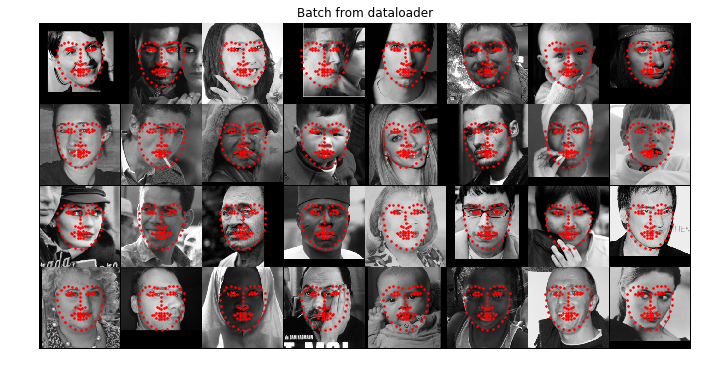

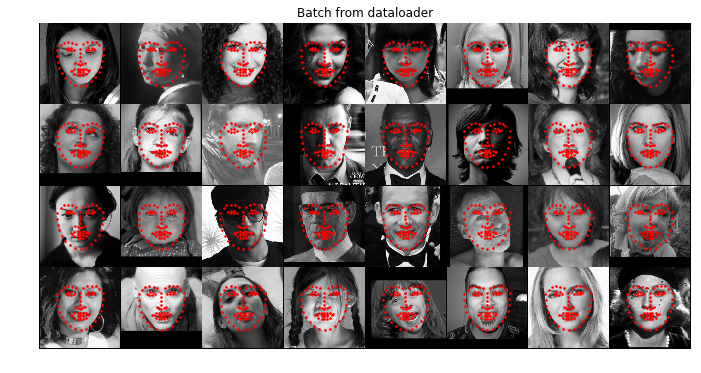

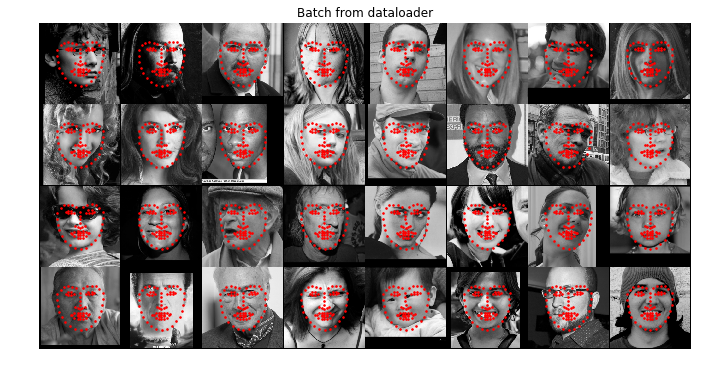

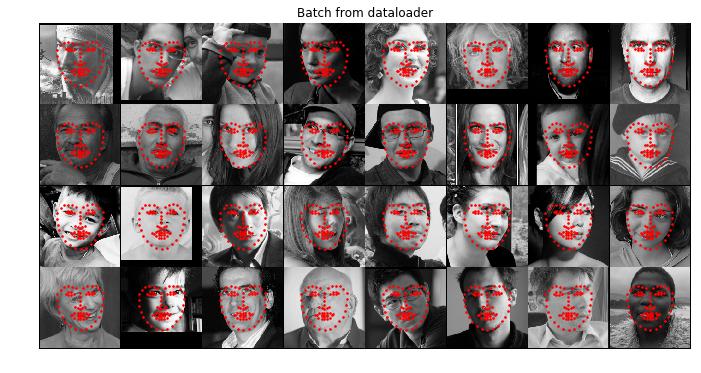

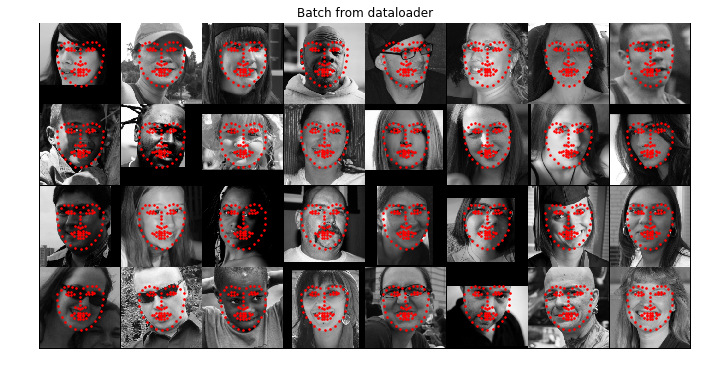

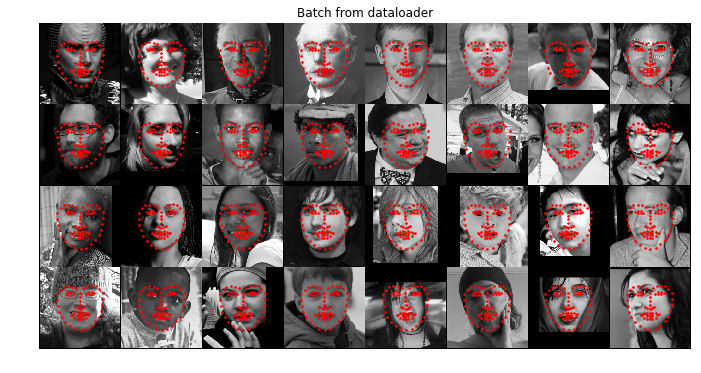

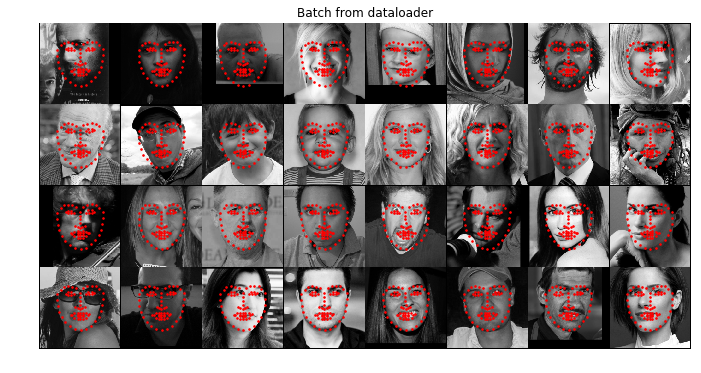

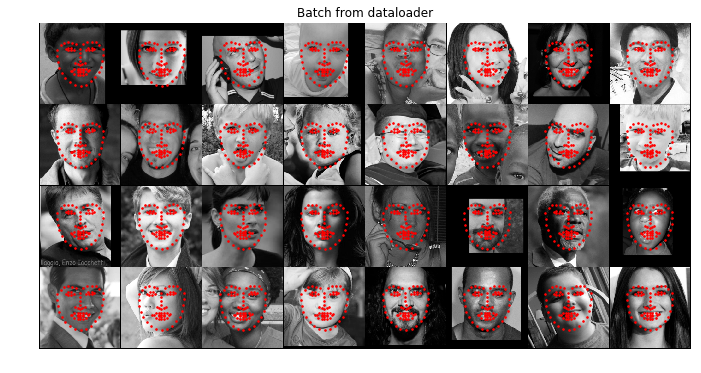

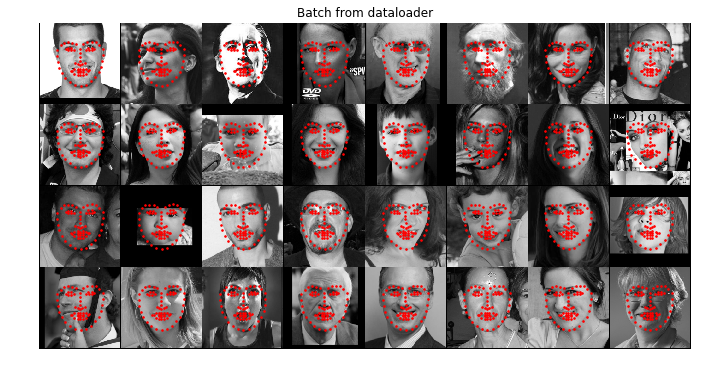

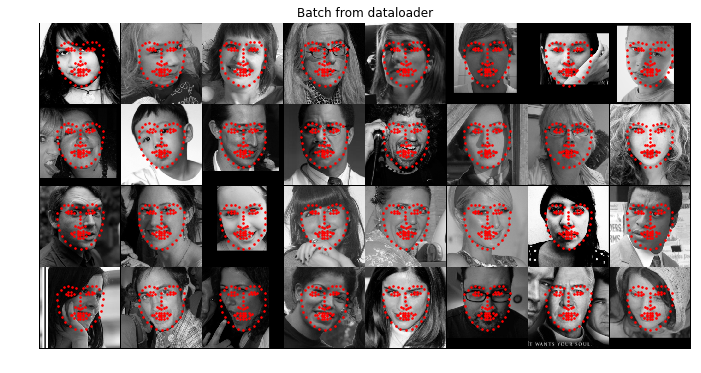

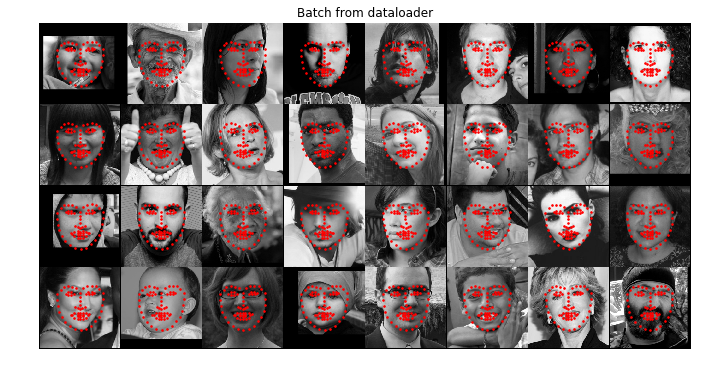

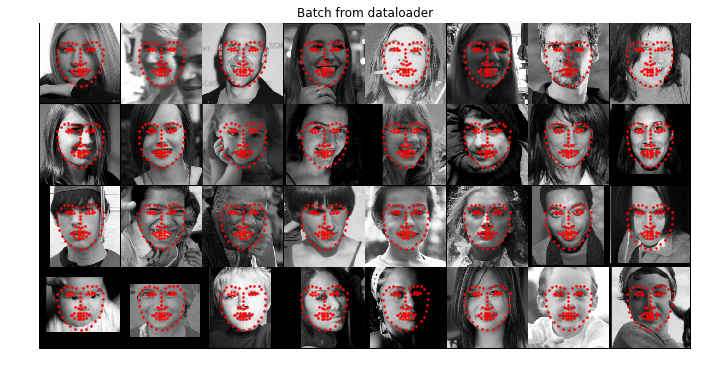

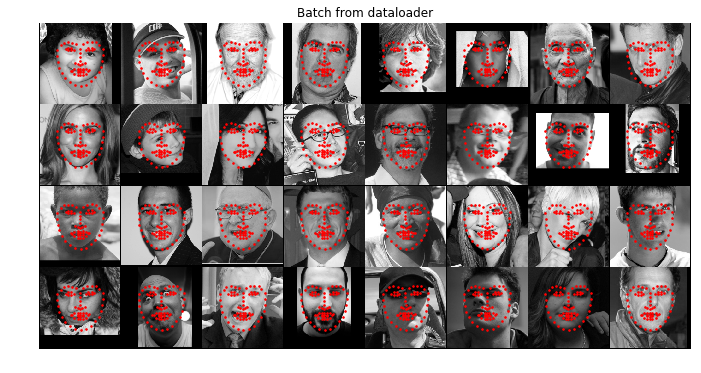

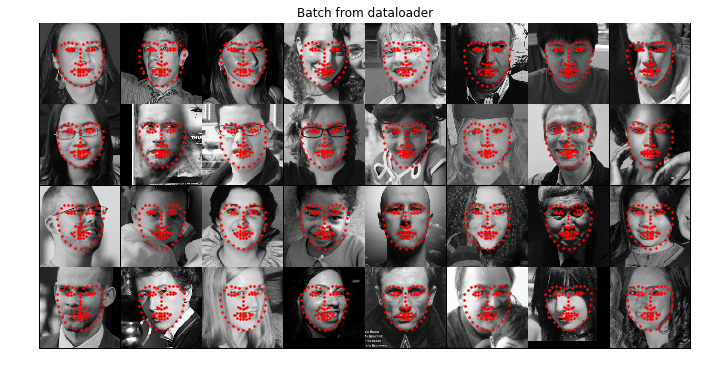

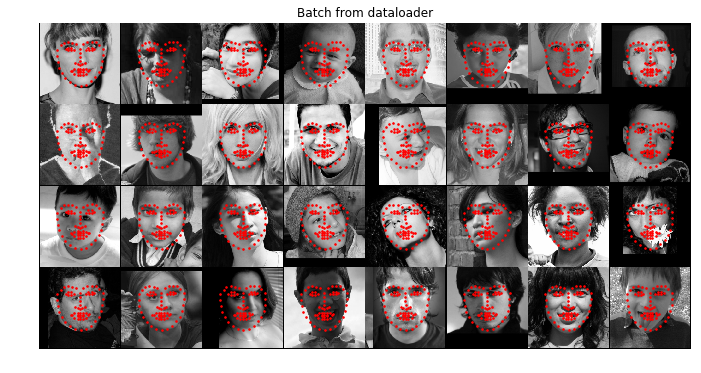

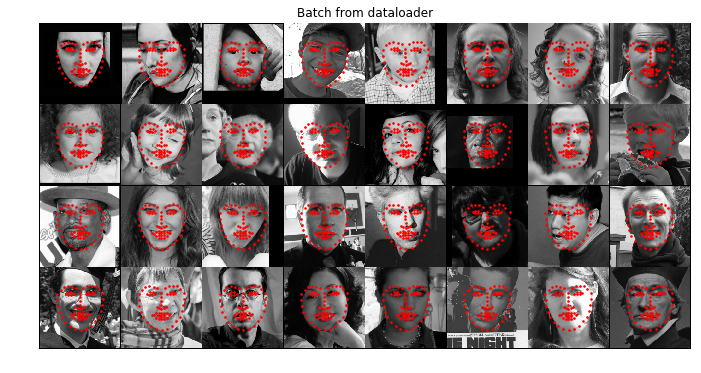

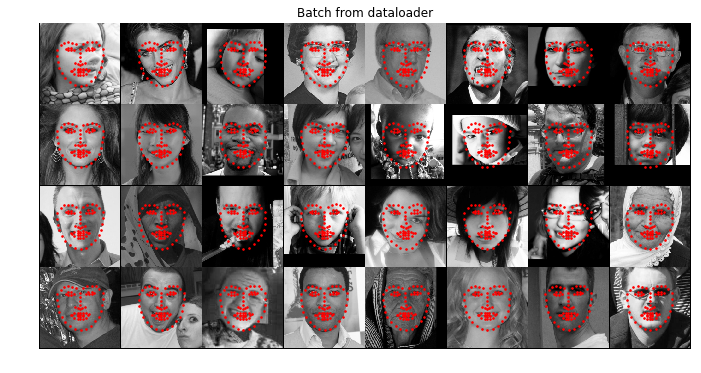

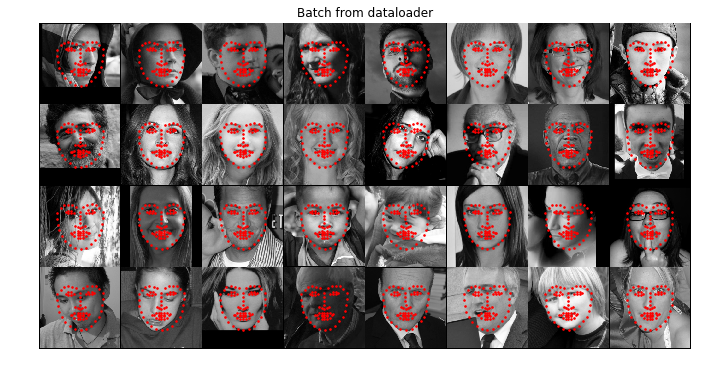

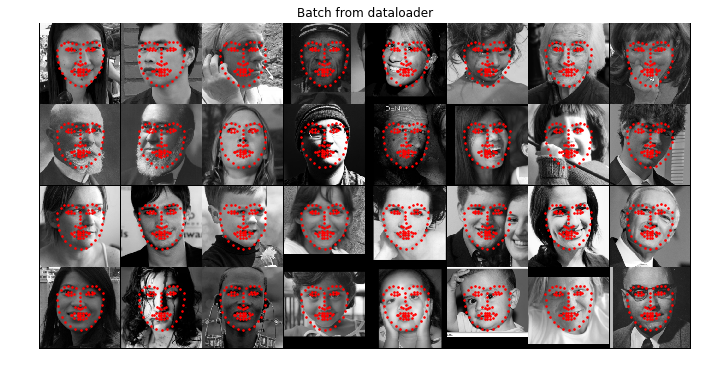

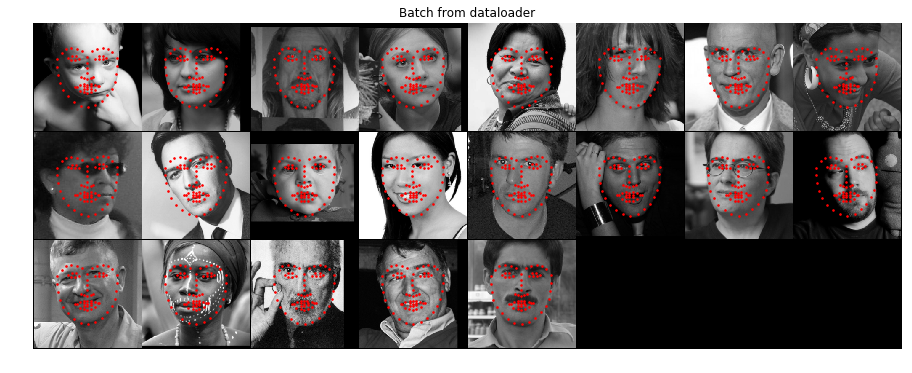

In [30]:
for i_batch, sample_batched in enumerate(valid_loader):
    
    predicted_landmarks = best_net(torch.autograd.Variable(sample_batched['image'], volatile=False)).cpu().data
    plt.figure(figsize=(20,6))
    show_landmarks_batch({'image': sample_batched['image'], 'landmarks': predicted_landmarks})
    plt.axis('off')
    plt.ioff()
    plt.show()

### Common test

In [ ]:
transforms = Compose([
                   CropFace(),
                   ToGray(),
                   ToTensor()
                 ])

In [ ]:
# load the dataset
dataset = FaceLandmarksDataset(csv_file='../data/common_test.csv',
                               root_dir='../data/',
                               transform=transforms)

common_loader = torch.utils.data.DataLoader(dataset, 
                batch_size=batch_size, num_workers=4)

In [ ]:
loss = 0
for i_batch, sample_batched in enumerate(common_loader):
    
    predicted_landmarks = best_net(torch.autograd.Variable(sample_batched['image'], volatile=False)).cpu().data
    
    loss += predicted_landmarks.shape[0]*criterion(predicted_landmarks, sample_batched['landmarks'])
    
    plt.figure(figsize=(20,6))
    show_landmarks_batch({'image': sample_batched['image'], 'landmarks': predicted_landmarks})
    plt.axis('off')
    plt.ioff()
    plt.show()

In [ ]:
loss/len(dataset)

### Challenging test

In [ ]:
# load the dataset
challenging_set = FaceLandmarksDataset(csv_file='../data/challenging_test.csv',
                               root_dir='../data/',
                               transform=transforms)

challeging_loader = torch.utils.data.DataLoader(challenging_set, 
                batch_size=batch_size, num_workers=4)

In [ ]:
loss = 0
for i_batch, sample_batched in enumerate(challeging_loader):
    
    predicted_landmarks = best_net(torch.autograd.Variable(sample_batched['image'], volatile=False)).cpu().data
    
    loss += predicted_landmarks.shape[0]*criterion(predicted_landmarks, sample_batched['landmarks'])
    
    plt.figure(figsize=(20,6))
    show_landmarks_batch({'image': sample_batched['image'], 'landmarks': predicted_landmarks})
    plt.axis('off')
    plt.ioff()
    plt.show()

In [ ]:
loss/len(challenging_set)

In [ ]:
np.sum([v.numel() for v in net.parameters()])